In [21]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


(128, 128)


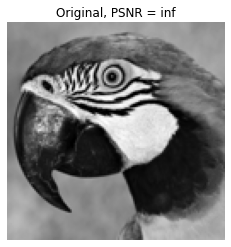

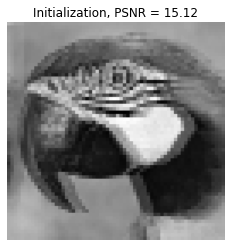

In [22]:
problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=128, W=128, sigma=0, subsampling=2)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=128, W=128)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=128, W=128)

(-0.5, 63.5, 63.5, -0.5)

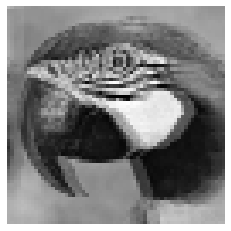

In [23]:
measurements = problem.y.reshape(64,64)
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

After gradient update: 0 0 15.442800659725153
After denoising update: 0 0 15.451955299961089

After gradient update: 0 1 15.77141769314279
After denoising update: 0 1 15.776281968738314

After gradient update: 0 2 16.088241801134494
After denoising update: 0 2 16.09049131313958

After gradient update: 0 3 16.39901458824749
After denoising update: 0 3 16.399820958716546

After gradient update: 0 4 16.68798069660215
After denoising update: 0 4 16.687911744643408

After gradient update: 0 5 16.976909645824247
After denoising update: 0 5 16.976867099925425

After gradient update: 0 6 17.251745019521202
After denoising update: 0 6 17.251355922783127

After gradient update: 0 7 17.51284895536677
After denoising update: 0 7 17.511646580158256

After gradient update: 0 8 17.758482023850526
After denoising update: 0 8 17.756855947913937

After gradient update: 0 9 18.00340676618894
After denoising update: 0 9 18.00142549830297

After gradient update: 1 0 18.1758512967847
After denoising update:

After gradient update: 8 8 21.21240715808051
After denoising update: 8 8 21.207380247377408

After gradient update: 8 9 21.216666195583937
After denoising update: 8 9 21.211817678368305

After gradient update: 9 0 21.220368675764977
After denoising update: 9 0 21.215505826304142

After gradient update: 9 1 21.225710655793456
After denoising update: 9 1 21.220904184090976

After gradient update: 9 2 21.231115648040287
After denoising update: 9 2 21.226178987073844

After gradient update: 9 3 21.234776676563843
After denoising update: 9 3 21.23019493504414

After gradient update: 9 4 21.239780429347533
After denoising update: 9 4 21.23529496394319

After gradient update: 9 5 21.244900660365907
After denoising update: 9 5 21.24033005719089

After gradient update: 9 6 21.24967642842167
After denoising update: 9 6 21.24527133752091

After gradient update: 9 7 21.25342661469511
After denoising update: 9 7 21.24908458934421

After gradient update: 9 8 21.257510922213847
After denoising update

After gradient update: 17 5 21.360084386105022
After denoising update: 17 5 21.359072966531556

After gradient update: 17 6 21.359487890293934
After denoising update: 17 6 21.358630994842617

After gradient update: 17 7 21.360353798668555
After denoising update: 17 7 21.359444758461365

After gradient update: 17 8 21.36056561795058
After denoising update: 17 8 21.359704596191456

After gradient update: 17 9 21.360504345545888
After denoising update: 17 9 21.359693656943875

After gradient update: 18 0 21.36041616071845
After denoising update: 18 0 21.359595592869717

After gradient update: 18 1 21.360409544459632
After denoising update: 18 1 21.359664744333898

After gradient update: 18 2 21.3604729211007
After denoising update: 18 2 21.35971152807509

After gradient update: 18 3 21.36021937427254
After denoising update: 18 3 21.359473598903648

After gradient update: 18 4 21.360450531390907
After denoising update: 18 4 21.359736898197013

After gradient update: 18 5 21.36057510890838


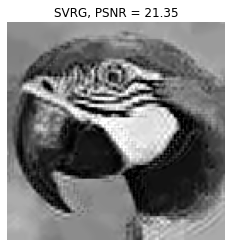

In [32]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.01, patch_size=5, patch_distance=12, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.01, tt=100, T2=10, 
                                                   mini_batch_size=problem.num_meas//2, verbose=True)

psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(128,128), title="SVRG", H=128, W=128)

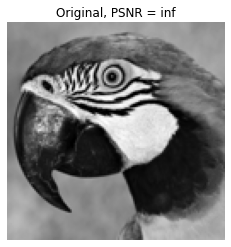

In [27]:
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=128, W=128)